# Image Classification of Australian Animals

William Li z5257749

**Would recommend running this file in a new empty directory, as it makes several subfolders (which could overwrite existing ones)**

The goal of the project is to create a model that can classify a selection of Australian animals. There are 8 animals:
- Cockatoo
- Dingo
- Kangaroo
- Koala
- Kookaburra
- Platypus
- Seadragon
- Wombat

The metric used to assess models is categorical accuracy.

## Import packages and set seed

In [74]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import itertools
import pickle
import hiplot as hip
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

from tensorflow.keras.utils import load_img, img_to_array, set_random_seed
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Resizing
from tensorflow.keras.callbacks import EarlyStopping

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


## Download Data

In [121]:
if not Path("Data").exists():
    !wget https://github.com/williamrjli/actl3143-project/raw/main/Data.zip
    !unzip Data.zip
    
#Grid search takes too long to run, so will download results from before
if not Path("Grid Search Results").exists():
    !wget https://github.com/williamrjli/actl3143-project/raw/main/Grid%20Search%20Results.zip
    !unzip Grid\ Search\ Results.zip

--2022-07-27 17:28:20--  https://github.com/williamrjli/actl3143-project/raw/main/Grid%20Search%20Results.zip
Resolving github.com (github.com)... 20.248.137.48
Connecting to github.com (github.com)|20.248.137.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/williamrjli/actl3143-project/main/Grid%20Search%20Results.zip [following]
--2022-07-27 17:28:21--  https://raw.githubusercontent.com/williamrjli/actl3143-project/main/Grid%20Search%20Results.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17851 (17K) [application/zip]
Saving to: ‘Grid Search Results.zip’

Grid Search Results 100%[===================>]  17.43K  --.-KB/s    in 0.001s  

2022-07-27 17:28:21 (24.9 MB/s) - 

In [76]:
tf.random.set_seed(777)

## Data loading and preprocessing

Data is located in the "Data" folder, with images of each animal being in a different subfolder.

There are 200 images for each animal. The images were collected from Google Images with the help of the Image Downloader extension. 
https://chrome.google.com/webstore/detail/image-downloader/cnpniohnfphhjihaiiggeabnkjhpaldj 

They were selected manually to ensure accuracy and avoid duplicates (though the latter is not guaranteed as I can't perfectly recall 200 images)

In [77]:
labels = []
data_raw = []

folder_list = os.listdir('Data')
folder_list.sort()
for folder_name in folder_list:
    folder_path = os.path.join('Data', folder_name)
    
    # There are some system files that are not directories
    if not os.path.isdir(folder_path):
        continue
        
    file_list = os.listdir(folder_path)
    file_list.sort()
    for file_name in file_list:
        if file_name.endswith('.jpeg'):
            file_path = os.path.join(folder_path, file_name)
            img = load_img(file_path)
            img_array = img_to_array(img)
            #normalise inputs from [0, 255] to [0, 1]
            img_array /= 255
            
            data_raw.append(img_array)
            
            labels.append(folder_name)

In [78]:
labels = np.array(labels)

enc = OneHotEncoder(sparse=False)
labels_oh = enc.fit_transform(labels.reshape(-1,1))

train_test_split used 3 times to segment data into 4 sets. Their purpose and number of examples per class are:
- Training (96)
- Validation for early-stopping (32)
- Validation for hyperparameter tuning (32) and
- Test (40)

https://stats.stackexchange.com/questions/422671/early-stopping-together-with-hyperparameter-tuning-in-neural-networks

Using the same dataset for both early-stopping and hyperparameter tuning would mean choosing the epoch with the best performance on the dataset, while also evaluating model performance using that same dataset. This may result in an optimistic validation error.

The downside of having two validation sets is less training data for hyperparameter tuning. This disadvantage is not present for the final model however, as one of the validation sets can be combined into the training set at that point.

After considering the pros and cons, the choice was made to use 2 validation sets.

Validation set for early-stopping explicitly defined here rather than using validation_split in model.train as stratify is only available here.

In [79]:
X_train_val_raw, X_test_raw, y_train_val, y_test = train_test_split(
    data_raw, labels_oh, test_size=0.2, shuffle=True, random_state=777, stratify=labels)

X_train_es_raw, X_val_raw, y_train_es, y_val = train_test_split(
    X_train_val_raw, y_train_val, test_size=0.2, shuffle=True, random_state=777, stratify=y_train_val)

X_train_raw, X_es_raw, y_train, y_es = train_test_split(
    X_train_es_raw, y_train_es, test_size=0.25, shuffle=True, random_state=777, stratify=y_train_es)

In [80]:
def list_to_resized_array(img_list):
    return np.array([tf.image.resize(img, (128, 128)) for img in img_list])

In [81]:
#Resize images
X_train = list_to_resized_array(X_train_raw)
X_es = list_to_resized_array(X_es_raw)
X_val = list_to_resized_array(X_val_raw)
X_test = list_to_resized_array(X_test_raw)

### Exploratory Data Analysis

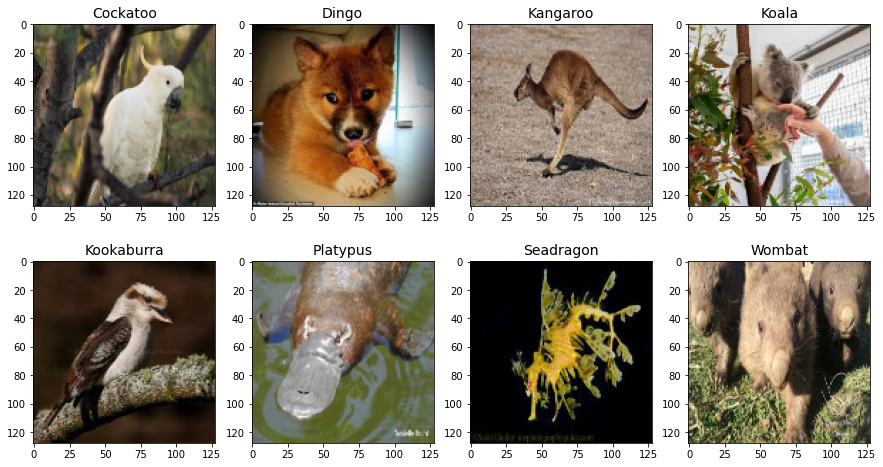

In [82]:
fig = plt.figure(figsize=(15, 8))
for class_index in range(y_train.shape[1]):   
    plt.subplot(2, 4, class_index+1)
    image_index = np.where(y_train[:, class_index])[0][0]
    plt.imshow(X_train[image_index])
    plt.title(enc.categories_[0][class_index], fontdict={'fontsize': 14})
plt.savefig(os.path.join('Plots', 'animal_examples.jpg'), dpi=200)
plt.show()

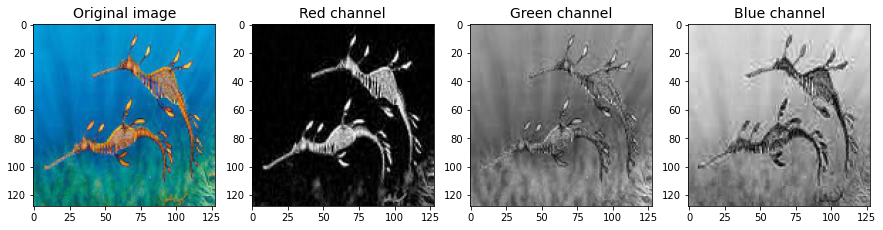

In [83]:
fig = plt.figure(figsize=(15, 5))
img_index=85

plt.subplot(1, 4, 1)
plt.imshow(X_train[img_index])
plt.title('Original image', fontdict={'fontsize': 14})

plt.subplot(1, 4, 2)
plt.imshow(X_train[img_index, :, :, 0], cmap='gray')
plt.title('Red channel', fontdict={'fontsize': 14})

plt.subplot(1, 4, 3)
plt.imshow(X_train[img_index, :, :, 1], cmap='gray')
plt.title('Green channel', fontdict={'fontsize': 14})

plt.subplot(1, 4, 4)
plt.imshow(X_train[img_index, :, :, 2], cmap='gray')
plt.title('Blue channel', fontdict={'fontsize': 14})

plt.savefig(os.path.join('Plots', 'colour_channels.jpg'), dpi=200)
plt.show()

### Image augmentation
Image augmentation may be helpful for the training set, as we have a fairly small dataset.

In [84]:
def zoom_corner(img_list, position='random', proportion=0.8, random_state=777):
    set_random_seed(random_state)
    new_img_list = []
    rand = position == 'random'
    
    for img in img_list:
        height = img.shape[0]
        width = img.shape[1]
        new_height = round(height*proportion)
        new_width = round(width*proportion)
        
        if rand:
            position = random.choice(['top-left', 'top-right', 'bottom-left', 'bottom-right'])
        
        if position == 'top-left':
            new_img = img[:new_height, :new_width, :]
        elif position == 'top-right':
            new_img = img[:new_height, -new_width:, :]
        elif position == 'bottom-left':
            new_img = img[-new_height:, :new_width, :]
        elif position == 'bottom-right':
            new_img = img[-new_height:, -new_width:, :]
        else:
            raise Exception("Invalid position")
        
        new_img_list.append(new_img)
        
    new_img_array = list_to_resized_array(new_img_list)
    return new_img_array

In [85]:
def rotate(img_list, rotation_angle, zoom_factor=-0.25, random_state=777):
    set_random_seed(random_state)
    new_img_list = []
    rotation_factor = rotation_angle/360
    
    seq = Sequential([
        RandomRotation((-rotation_factor, rotation_factor), fill_mode='reflect'),
        #Zoom in as rotation causes corners to be outside the boundaries
        #Setting both lower and upper bound equal means deterministic behaviour
        RandomZoom((zoom_factor, zoom_factor))
    ])
    
    for img in img_list:
        
        new_img = seq(img, training=True)
        new_img_list.append(new_img)
    
    new_img_array = list_to_resized_array(new_img_list)
    return new_img_array

In [86]:
def augment_6x(X_raw):
    X = list_to_resized_array(X_raw)
    
    X_random_corner = zoom_corner(X_raw, position='random', random_state=777)
    
    #rotate 12 degrees at most, otherwise it wouldn't be a realistic image any more
    X_rotate = rotate(X_raw, 12, random_state=777)
    
    X_flip = X[:, :, ::-1, :]
    
    X_random_corner_2 = zoom_corner(X_raw, position='random', random_state=778)
    X_random_corner_flip = X_random_corner_2[:, :, ::-1, :]
    
    #rotate 12 degrees at most, otherwise it wouldn't be a realistic image any more
    X_rotate_2 = rotate(X_raw, 12, random_state=778)
    X_rotate_flip = X_rotate_2[:, :, ::-1, :]
    
    X_variations = [X, X_random_corner, X_rotate, X_flip, X_random_corner_flip, X_rotate_flip]
    X_aug = np.concatenate(X_variations)
    return X_aug

In [87]:
X_train_aug = augment_6x(X_train_raw)
y_train_aug = np.concatenate([y_train]*6)
X_es_aug = augment_6x(X_es_raw)
y_es_aug = np.concatenate([y_es]*6)

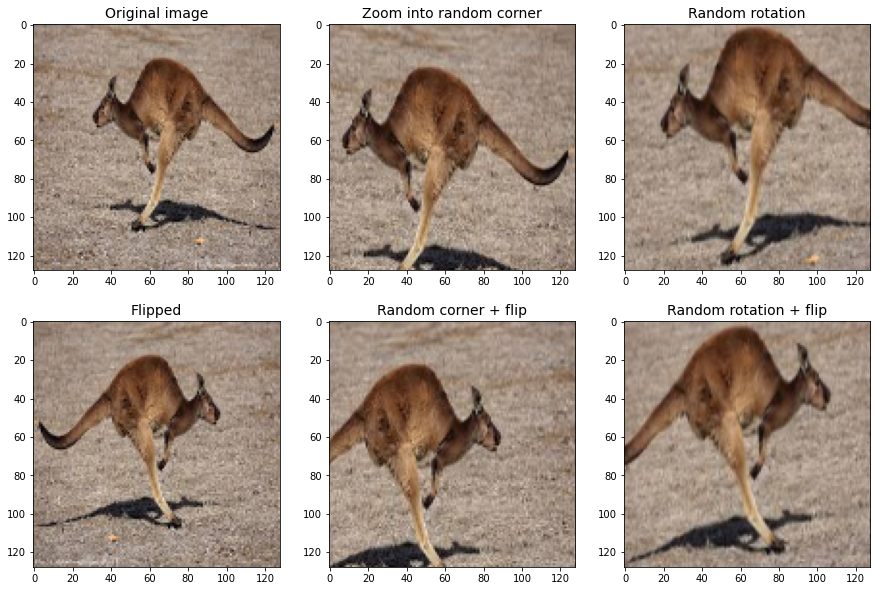

In [88]:
fig = plt.figure(figsize=(15, 10))
img_index = 0
n_train = len(X_train_raw)
font_size = 14

plt.subplot(2, 3, 1)
plt.imshow(X_train_aug[img_index])
plt.title('Original image', fontdict={'fontsize': font_size})

plt.subplot(2, 3, 2)
plt.imshow(X_train_aug[img_index+n_train*1])
plt.title('Zoom into random corner', fontdict={'fontsize': font_size})

plt.subplot(2, 3, 3)
plt.imshow(X_train_aug[img_index+n_train*2])
plt.title('Random rotation', fontdict={'fontsize': font_size})

plt.subplot(2, 3, 4)
plt.imshow(X_train_aug[img_index+n_train*3])
plt.title('Flipped', fontdict={'fontsize': font_size})

plt.subplot(2, 3, 5)
plt.imshow(X_train_aug[img_index+n_train*4])
plt.title('Random corner + flip', fontdict={'fontsize': font_size})

plt.subplot(2, 3, 6)
plt.imshow(X_train_aug[img_index+n_train*5])
plt.title('Random rotation + flip', fontdict={'fontsize': font_size})

plt.savefig(os.path.join('Plots', 'augment_demo.jpg'), dpi=200)
plt.show()

In [89]:
#Shuffle after adding the modified images
set_random_seed(777)
perm = np.random.permutation(X_train_aug.shape[0])
X_train_aug = X_train_aug[perm]
y_train_aug = y_train_aug[perm]

perm_2 = np.random.permutation(X_es_aug.shape[0])
X_es_aug = X_es_aug[perm_2]
y_es_aug = y_es_aug[perm_2]

## Benchmark model: Logistic regression

In [17]:
def resize_array(img_array, new_size):
    img_array_small = []
    for img in img_array:
        img_array_small.append(tf.image.resize(img, new_size))
    return np.array(img_array_small)

In [130]:
#Logistic regression doesn't need early stopping, so the data can be used for training
X_train_lr = np.concatenate((X_train, X_es))
y_train_lr = np.concatenate((y_train, y_es))

#128x128 RGB has too many features for logistic regression, so resize 8x8 so there are 8*8*3=192 features
X_train_lr_8 = resize_array(X_train_lr, (8, 8))
X_val_8 = resize_array(X_val, (8, 8))

X_train_lr_flat = X_train_lr_8.reshape(X_train_lr.shape[0], -1)
X_val_flat = X_val_8.reshape(X_val.shape[0], -1)
y_train_lr_1d = np.argmax(y_train_lr, axis=1)
y_val_1d = np.argmax(y_val, axis=1)

#Removing regularisation with penalty='none' performs worse
lr_model = LogisticRegression(max_iter=1000, penalty='l2')
lr_model.fit(X_train_lr_flat, y_train_lr_1d)
y_val_pred_1d = lr_model.predict(X_val_flat)
np.mean(y_val_1d == y_val_pred_1d)

0.46875

Logistic regression gives an accuracy of 46.88% in validation set. It is not great but considerably higher than random guessing (which would give an accuracy of 12.5%).

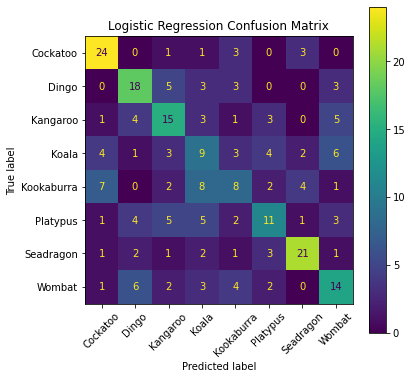

In [19]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Logistic Regression Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_val_1d, y_val_pred_1d, ax=ax, display_labels=enc.categories_[0])
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(os.path.join('Plots', 'lr_confusion.jpg'), dpi=300, bbox_inches='tight')
plt.show()

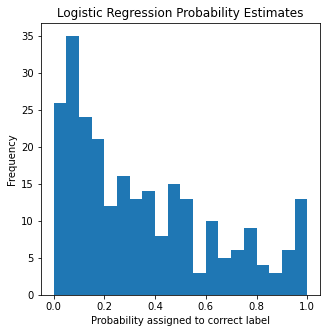

In [20]:
y_val_pred = lr_model.predict_proba(X_val_flat)
correct_label_probs = y_val_pred[np.arange(y_val_pred.shape[0]), y_val_1d]
plt.figure(figsize=(5, 5))
plt.title("Logistic Regression Probability Estimates")
plt.hist(correct_label_probs, bins=np.arange(0, 1.05, 0.05))
plt.xlabel("Probability assigned to correct label")
plt.ylabel("Frequency")
plt.savefig(os.path.join('Plots', 'lr_prob_hist.jpg'), dpi=300)
plt.show()

In [21]:
coef = np.reshape(lr_model.coef_, (8, 64, 3))
np.mean(coef, axis=1)

array([[-0.10885554,  0.21965856,  0.02685117],
       [ 0.21847363, -0.11012683, -0.03689482],
       [ 0.18810731,  0.03574797, -0.14230536],
       [-0.01979021, -0.016264  ,  0.05525384],
       [-0.09491482,  0.06925052,  0.02929587],
       [ 0.00105362, -0.13906615,  0.01703521],
       [-0.34465426,  0.16420276,  0.00821149],
       [ 0.16058029, -0.22340282,  0.04255261]])

These are the average coefficients of each colour channel across all 64 pixels. It could be possible to interpret some of these coefficients. For example, the coefficient of red is reasonably positive on average for dingo and kangaroo classes, which is likely due to both animals having a reddish colour, and inhabiting drier areas which may have more red color. 

## Simple neural network

In [90]:
def define_simple_nn(resizing_size, neurons_1, neurons_2, neurons_3, dropout_rate, activation):
    model = Sequential()
    model.add(InputLayer(input_shape=(128, 128, 3)))
    model.add(Resizing(resizing_size, resizing_size))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_1, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons_2, activation=activation))
    model.add(Dropout(dropout_rate))
    if neurons_3 is not None:
        model.add(Dense(neurons_3, activation=activation))
        model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation='softmax'))
    return model

In [91]:
simple_nn_param_options = {
    'resizing_size':[8, 16, 32, 64],
    'neurons_1': [512, 1024],
    'neurons_2': [256, 512],
    'neurons_3': [None, 128, 256],
    'dropout_rate': [0, 0.2, 0.4],
    'activation': ['relu', 'tanh']
}

In [92]:
#Get all hyperparameter combinations by computing Cartesian product
simple_nn_combo_lists = itertools.product(*simple_nn_param_options.values())
simple_nn_combo_dicts = []
for combo in simple_nn_combo_lists:
    simple_nn_combo_dicts.append(dict(zip(simple_nn_param_options.keys(), combo)))
print(f"{len(simple_nn_combo_dicts)} hyperparameter combinations")

288 hyperparameter combinations


In [93]:
#Grid search code, takes 2 hours to run on my computer
"""
es = EarlyStopping(patience=20, restore_best_weights=True)
for param_combo in simple_nn_combo_dicts:
    print(param_combo)
    set_random_seed(777)
    model = define_simple_nn(**param_combo)
    model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es),
              batch_size=128, verbose=0)
    param_combo['train_loss'], param_combo['train_acc'] = model.evaluate(X_train, y_train, verbose=0)
    param_combo['es_loss'], param_combo['es_acc'] = model.evaluate(X_es, y_es, verbose=0)
    param_combo['val_loss'], param_combo['val_acc'] = model.evaluate(X_val, y_val, verbose=0)
    
simple_nn_df = pd.DataFrame(simple_nn_combo_dicts)
simple_nn_df.to_csv(os.path.join('Grid Search Results', 'simple_nn_grid_search.csv'), index=False)
"""

"\nes = EarlyStopping(patience=20, restore_best_weights=True)\nfor param_combo in simple_nn_combo_dicts:\n    print(param_combo)\n    set_random_seed(777)\n    model = define_simple_nn(**param_combo)\n    model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])\n    model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es),\n              batch_size=128, verbose=0)\n    param_combo['train_loss'], param_combo['train_acc'] = model.evaluate(X_train, y_train, verbose=0)\n    param_combo['es_loss'], param_combo['es_acc'] = model.evaluate(X_es, y_es, verbose=0)\n    param_combo['val_loss'], param_combo['val_acc'] = model.evaluate(X_val, y_val, verbose=0)\n    \nsimple_nn_df = pd.DataFrame(simple_nn_combo_dicts)\nsimple_nn_df.to_csv(os.path.join('Grid Search Results', 'simple_nn_grid_search.csv'), index=False)\n"

### Analyse grid search

In [94]:
simple_nn_df = pd.read_csv(os.path.join('Grid Search Results', 'simple_nn_grid_search.csv'))
exp = hip.Experiment.from_dataframe(simple_nn_df)
exp.display_data(hip.Displays.PARALLEL_PLOT).update(
    {'hide': ['train_loss', 'train_acc', 'es_loss', 'es_acc', 'val_loss']})
exp.display();

<IPython.core.display.Javascript object>

In [122]:
simple_nn_df_top_10 = simple_nn_df.sort_values('val_acc', ascending=False).head(10)
simple_nn_df_top_10.to_csv(os.path.join('Grid Search Results', 'simple_nn_grid_search_top_10.csv'))
simple_nn_df_top_10

resizing_size  neurons_1  neurons_2  neurons_3  dropout_rate activation  \
270             64       1024        512        NaN           0.0       relu   
133             16       1024        512      128.0           0.0       tanh   
109             16       1024        256        NaN           0.0       tanh   
110             16       1024        256        NaN           0.2       relu   
73              16        512        256        NaN           0.0       tanh   
101             16        512        512      128.0           0.4       tanh   
129             16       1024        512        NaN           0.2       tanh   
114             16       1024        256      128.0           0.0       relu   
79              16        512        256      128.0           0.0       tanh   
75              16        512        256        NaN           0.2       tanh   

     train_loss  train_acc   es_loss    es_acc  val_loss   val_acc  
270    1.077177   0.630208  1.564916  0.421875  1.537749  0.496094  
133    0.844326   0.716146  1.562167  0.445312  1.542491  0.488281  
109    0.963983   0.675781  1.520753  0.484375  1.478022  0.488281  
110    0.939313   0.694010  1.496596  0.460938  1.487772  0.488281  
73     1.156322   0.587240  1.488302  0.472656  1.425003  0.488281  
101    1.194734   0.583333  1.452278  0.484375  1.445847  0.484375  
129    1.086882   0.638021  1.480712  0.468750  1.458580  0.484375  
114    0.787186   0.731771  1.535329  0.503906  1.557373  0.480469  
79     0.844959   0.716146  1.532678  0.453125  1.495917  0.480469  
75     0.858888   0.723958  1.444493  0.457031  1.411378  0.480469

The best set of parameters resulted in an accuracy of 48.44%, slightly higher than logistic regression. However, it is quite likely that simple neural network is actually inferior to logistic regression as only 2 of the 288 parameter combinations outperformed it, which could easily be due to random variance.

### Train model with optimal hyperparameters and plot confusion matrix

In [106]:
set_random_seed(777)
#This top combination might have gotten lucky, as all other top combinations use resizing_size=16
model = define_simple_nn(resizing_size=64, neurons_1=1024, neurons_2=512, neurons_3=None,
                         dropout_rate=0, activation='relu')
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 64, 64, 3)         0         
                                                                 
 flatten_8 (Flatten)         (None, 12288)             0         
                                                                 
 dropout_24 (Dropout)        (None, 12288)             0         
                                                                 
 dense_24 (Dense)            (None, 1024)              12583936  
                                                                 
 dropout_25 (Dropout)        (None, 1024)              0         
                                                                 
 dense_25 (Dense)            (None, 512)               524800    
                                                                 
 dropout_26 (Dropout)        (None, 512)             

In [107]:
model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
es = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
hist = model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es), batch_size=128)

Epoch 1/100
36/36 [==============================] - 16s 348ms/step - loss: 6.3130 - categorical_accuracy: 0.1962 - val_loss: 2.0867 - val_categorical_accuracy: 0.2344
Epoch 2/100
36/36 [==============================] - 7s 186ms/step - loss: 1.7677 - categorical_accuracy: 0.3305 - val_loss: 1.7594 - val_categorical_accuracy: 0.3477
Epoch 3/100
36/36 [==============================] - 3s 69ms/step - loss: 1.6863 - categorical_accuracy: 0.3596 - val_loss: 1.7390 - val_categorical_accuracy: 0.3711
Epoch 4/100
36/36 [==============================] - 5s 143ms/step - loss: 1.6013 - categorical_accuracy: 0.3987 - val_loss: 1.6783 - val_categorical_accuracy: 0.3984
Epoch 5/100
36/36 [==============================] - 4s 106ms/step - loss: 1.5972 - categorical_accuracy: 0.4071 - val_loss: 1.8305 - val_categorical_accuracy: 0.3359
Epoch 6/100
36/36 [==============================] - 2s 67ms/step - loss: 1.5890 - categorical_accuracy: 0.4156 - val_loss: 1.6645 - val_categorical_accuracy: 0.3555

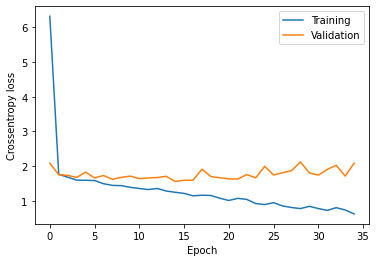

In [108]:
#Plot loss over epochs
plt.plot(hist.history['loss'], label="Training")
plt.plot(hist.history['val_loss'], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Crossentropy loss")
plt.show()

In [109]:
model.evaluate(X_val, y_val)

8/8 [==============================] - 2s 84ms/step - loss: 1.5377 - categorical_accuracy: 0.4961


[1.5377492904663086, 0.49609375]

In [110]:
y_val_pred = model.predict(X_val)
#Convert from 2D array of probabilities to predictions
y_val_pred_1d = np.argmax(y_val_pred, axis=1)
y_val_1d = np.argmax(y_val, axis=1)

8/8 [==============================] - 0s 14ms/step


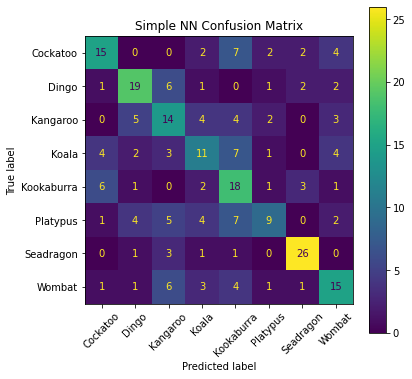

In [111]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Simple NN Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_val_1d, y_val_pred_1d, ax=ax, display_labels=enc.categories_[0])
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(os.path.join('Plots', 'simple_nn_confusion.jpg'), dpi=300, bbox_inches='tight')
plt.show()

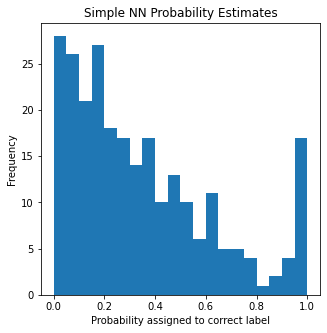

In [112]:
correct_label_probs = y_val_pred[np.arange(y_val_pred.shape[0]), y_val_1d]
plt.figure(figsize=(5, 5))
plt.hist(correct_label_probs, bins=np.arange(0, 1.05, 0.05))
plt.title("Simple NN Probability Estimates")
plt.xlabel("Probability assigned to correct label")
plt.ylabel("Frequency")
plt.savefig(os.path.join('Plots', 'simple_nn_prob_hist.jpg'), dpi=300)
plt.show()

## Convolutional neural network

Basic structure takes inspiration from classic CNNs including LeNet and AlexNet

In [35]:
def define_cnn(kernel_size_1, kernel_size_2, pooling, dropout_rate, activation):
    Pooling2D = MaxPooling2D if pooling == 'max' else AveragePooling2D
    model = Sequential()
    model.add(InputLayer(input_shape=(128, 128, 3)))
    model.add(Conv2D(64, kernel_size_1, strides=4, padding='same', activation=activation))
    model.add(Pooling2D(2))
    model.add(Conv2D(128, kernel_size_2, strides=1, padding='same', activation=activation))
    model.add(Pooling2D(2))
    model.add(Conv2D(256, 3, strides=1, padding='same', activation=activation))
    model.add(Pooling2D(2))
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation='softmax'))
    return model

In [36]:
cnn_param_options = {
    'kernel_size_1': [5, 7, 9, 11],
    'kernel_size_2': [3, 5],
    'pooling': ['average', 'max'],
    'dropout_rate': [0, 0.2, 0.4],
    'activation': ['relu', 'tanh']
}

In [37]:
#Get all hyperparameter combinations by computing Cartesian product
cnn_combo_lists = itertools.product(*cnn_param_options.values())
cnn_combo_dicts = []
for combo in cnn_combo_lists:
    cnn_combo_dicts.append(dict(zip(cnn_param_options.keys(), combo)))
print(f"{len(cnn_combo_dicts)} hyperparameter combinations")

96 hyperparameter combinations


In [38]:
#Takes 6 hours
"""
es = EarlyStopping(patience=20, restore_best_weights=True)
for param_combo in cnn_combo_dicts:
    print(param_combo)
    set_random_seed(777)
    model = define_cnn(**param_combo)
    model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es),
              batch_size=128, verbose=0)
    param_combo['train_loss'], param_combo['train_acc'] = model.evaluate(X_train, y_train, verbose=0)
    param_combo['es_loss'], param_combo['es_acc'] = model.evaluate(X_es, y_es, verbose=0)
    param_combo['val_loss'], param_combo['val_acc'] = model.evaluate(X_val, y_val, verbose=0)
    
cnn_df = pd.DataFrame(cnn_combo_dicts)
cnn_df.to_csv(os.path.join('Grid Search Results', 'cnn_grid_search.csv'), index=False)
"""

"\nes = EarlyStopping(patience=20, restore_best_weights=True)\nfor param_combo in cnn_combo_dicts:\n    print(param_combo)\n    set_random_seed(777)\n    model = define_cnn(**param_combo)\n    model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])\n    model.fit(X_train_aug, y_train_aug, epochs=100, callbacks=[es], validation_data=(X_es, y_es),\n              batch_size=128, verbose=0)\n    param_combo['train_loss'], param_combo['train_acc'] = model.evaluate(X_train, y_train, verbose=0)\n    param_combo['es_loss'], param_combo['es_acc'] = model.evaluate(X_es, y_es, verbose=0)\n    param_combo['val_loss'], param_combo['val_acc'] = model.evaluate(X_val, y_val, verbose=0)\n    \ncnn_df = pd.DataFrame(cnn_combo_dicts)\ncnn_df.to_csv(os.path.join('Grid Search Results', 'cnn_grid_search.csv'), index=False)\n"

In [124]:
cnn_df = pd.read_csv(os.path.join('Grid Search Results', 'cnn_grid_search.csv'))
exp = hip.Experiment.from_dataframe(cnn_df)
exp.display_data(hip.Displays.PARALLEL_PLOT).update(
    {'hide': ['train_loss', 'train_acc', 'es_loss', 'es_acc', 'val_loss', 'uid']})
exp.display();

<IPython.core.display.Javascript object>

In [123]:
cnn_df_top_10 = cnn_df.sort_values('val_acc', ascending=False).head(10)
cnn_df_top_10.to_csv(os.path.join('Grid Search Results', 'cnn_grid_search_top_10.csv'))
cnn_df_top_10

kernel_size_1  kernel_size_2 pooling  dropout_rate activation  train_loss  \
83             11              3     max           0.4       tanh    0.213926   
81             11              3     max           0.2       tanh    0.094098   
45              7              5     max           0.2       tanh    0.175627   
19              5              5     max           0.0       tanh    0.179916   
23              5              5     max           0.4       tanh    0.224900   
31              7              3     max           0.0       tanh    0.111251   
57              9              3     max           0.2       tanh    0.234146   
9               5              3     max           0.2       tanh    0.269055   
35              7              3     max           0.4       tanh    0.151631   
7               5              3     max           0.0       tanh    0.155949   

    train_acc   es_loss    es_acc  val_loss   val_acc  
83   0.934896  1.043297  0.675781  0.848450  0.710938  
81   0.985677  1.014049  0.667969  0.902371  0.703125  
45   0.958333  0.993392  0.660156  0.944306  0.695312  
19   0.981771  0.980056  0.667969  0.938630  0.695312  
23   0.947917  0.909614  0.679688  1.002481  0.695312  
31   0.986979  0.976626  0.667969  0.954626  0.687500  
57   0.933594  0.994624  0.675781  0.898830  0.687500  
9    0.927083  0.891751  0.679688  0.924825  0.679688  
35   0.962240  0.979781  0.695312  0.960252  0.679688  
7    0.984375  0.906346  0.691406  0.959523  0.675781

### Train model with optimal hyperparameters and plot confusion matrix

In [41]:
set_random_seed(777)
model = define_cnn(kernel_size_1=11, kernel_size_2=3, pooling='max', dropout_rate=0.4, activation='tanh')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        23296     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)       

In [42]:
model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
es = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
hist = model.fit(X_train_aug, y_train_aug, epochs=130, callbacks=[es], validation_data=(X_es, y_es), batch_size=128)

Epoch 1/130
36/36 [==============================] - 8s 214ms/step - loss: 2.0099 - categorical_accuracy: 0.2431 - val_loss: 1.6991 - val_categorical_accuracy: 0.3320
Epoch 2/130
36/36 [==============================] - 8s 236ms/step - loss: 1.7127 - categorical_accuracy: 0.3581 - val_loss: 1.5480 - val_categorical_accuracy: 0.4570
Epoch 3/130
36/36 [==============================] - 11s 306ms/step - loss: 1.5535 - categorical_accuracy: 0.4384 - val_loss: 1.3918 - val_categorical_accuracy: 0.5117
Epoch 4/130
36/36 [==============================] - 13s 359ms/step - loss: 1.4503 - categorical_accuracy: 0.4818 - val_loss: 1.3050 - val_categorical_accuracy: 0.5664
Epoch 5/130
36/36 [==============================] - 8s 233ms/step - loss: 1.3454 - categorical_accuracy: 0.5291 - val_loss: 1.2305 - val_categorical_accuracy: 0.5859
Epoch 6/130
36/36 [==============================] - 9s 237ms/step - loss: 1.2241 - categorical_accuracy: 0.5729 - val_loss: 1.2106 - val_categorical_accuracy: 0.5

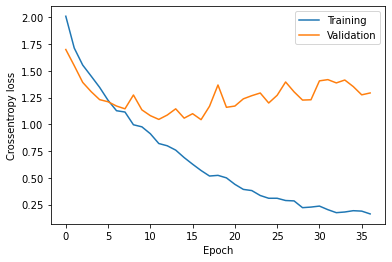

In [43]:
plt.plot(hist.history['loss'], label="Training")
plt.plot(hist.history['val_loss'], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Crossentropy loss")
plt.show()

In [44]:
model.evaluate(X_val, y_val)

8/8 [==============================] - 0s 21ms/step - loss: 0.8485 - categorical_accuracy: 0.7109


[0.8484503030776978, 0.7109375]

In [45]:
y_val_pred = model.predict(X_val)
#Convert from 2D array of probabilities to predictions
y_val_pred_1d = np.argmax(y_val_pred, axis=1)
y_val_1d = np.argmax(y_val, axis=1)

8/8 [==============================] - 0s 20ms/step


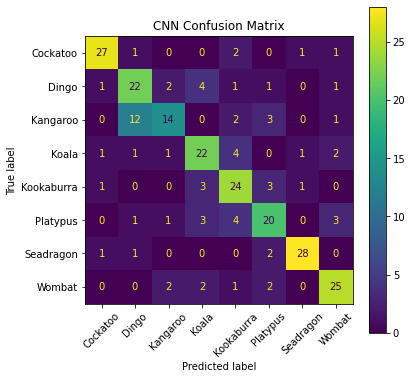

In [46]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('CNN Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_val_1d, y_val_pred_1d, ax=ax, display_labels=enc.categories_[0])
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(os.path.join('Plots', 'cnn_confusion.jpg'), dpi=300, bbox_inches='tight')
plt.show()

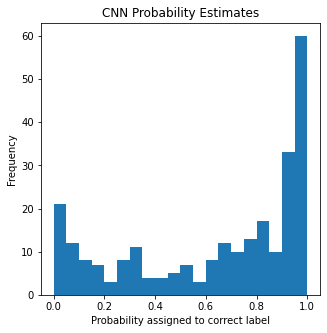

In [47]:
correct_label_probs = y_val_pred[np.arange(y_val_pred.shape[0]), y_val_1d]
plt.figure(figsize=(5, 5))
plt.hist(correct_label_probs, bins=np.arange(0, 1.05, 0.05))
plt.title("CNN Probability Estimates")
plt.xlabel("Probability assigned to correct label")
plt.ylabel("Frequency")
plt.savefig(os.path.join('Plots', 'cnn_prob_hist.jpg'), dpi=300)
plt.show()

## Make final model and evaluate on test set

In [48]:
#Can use one of the validation sets for training now, leave the other for early stopping
X_train_final = np.concatenate((X_train_aug, X_es_aug))
y_train_final = np.concatenate((y_train_aug, y_es_aug))

In [49]:
set_random_seed(777)
final_model = define_cnn(kernel_size_1=11, kernel_size_2=3, pooling='max', dropout_rate=0.4, activation='tanh')
final_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 64)        23296     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 256)       

In [50]:
final_model.compile(tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
es = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
hist = final_model.fit(X_train_final, y_train_final, epochs=100, callbacks=[es],
                 validation_data=(X_val, y_val), batch_size=128)

Epoch 1/100
48/48 [==============================] - 14s 274ms/step - loss: 1.9323 - categorical_accuracy: 0.2637 - val_loss: 1.5152 - val_categorical_accuracy: 0.4805
Epoch 2/100
48/48 [==============================] - 12s 251ms/step - loss: 1.6270 - categorical_accuracy: 0.4090 - val_loss: 1.3210 - val_categorical_accuracy: 0.5508
Epoch 3/100
48/48 [==============================] - 12s 253ms/step - loss: 1.4551 - categorical_accuracy: 0.4777 - val_loss: 1.2472 - val_categorical_accuracy: 0.5781
Epoch 4/100
48/48 [==============================] - 12s 242ms/step - loss: 1.3721 - categorical_accuracy: 0.5203 - val_loss: 1.1947 - val_categorical_accuracy: 0.6016
Epoch 5/100
48/48 [==============================] - 12s 245ms/step - loss: 1.2478 - categorical_accuracy: 0.5682 - val_loss: 1.2188 - val_categorical_accuracy: 0.5781
Epoch 6/100
48/48 [==============================] - 12s 244ms/step - loss: 1.1743 - categorical_accuracy: 0.5869 - val_loss: 1.1072 - val_categorical_accuracy:

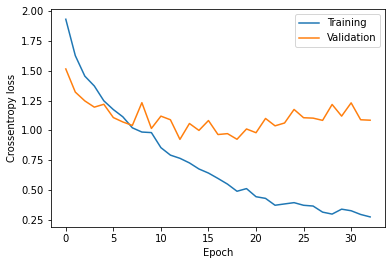

In [51]:
plt.plot(hist.history['loss'], label="Training")
plt.plot(hist.history['val_loss'], label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Crossentropy loss")
plt.show()

In [52]:
final_model.evaluate(X_test, y_test)

10/10 [==============================] - 1s 34ms/step - loss: 1.0143 - categorical_accuracy: 0.6781


[1.0143098831176758, 0.6781250238418579]

In [53]:
y_test_pred = final_model.predict(X_test)
y_test_pred_1d = np.argmax(y_test_pred, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

10/10 [==============================] - 0s 22ms/step


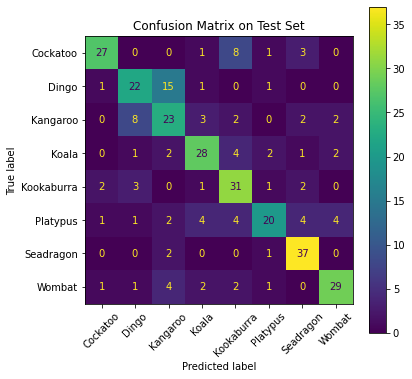

In [54]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Confusion Matrix on Test Set')
ConfusionMatrixDisplay.from_predictions(y_test_1d, y_test_pred_1d, ax=ax, display_labels=enc.categories_[0])
ax.tick_params(axis='x', labelrotation=45)
plt.savefig(os.path.join('Plots', 'test_confusion.jpg'), dpi=300, bbox_inches='tight')
plt.show()

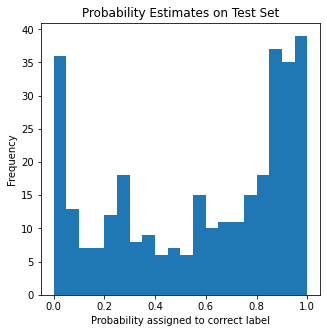

In [65]:
correct_label_probs = y_test_pred[np.arange(y_test_pred.shape[0]), y_test_1d]
plt.figure(figsize=(5, 5))
plt.hist(correct_label_probs, bins=np.arange(0, 1.05, 0.05))
plt.title("Probability Estimates on Test Set")
plt.xlabel("Probability assigned to correct label")
plt.ylabel("Frequency")
plt.savefig(os.path.join('Plots', 'test_prob_hist.jpg'), dpi=300)
plt.show()

### Showing predictions on some examples

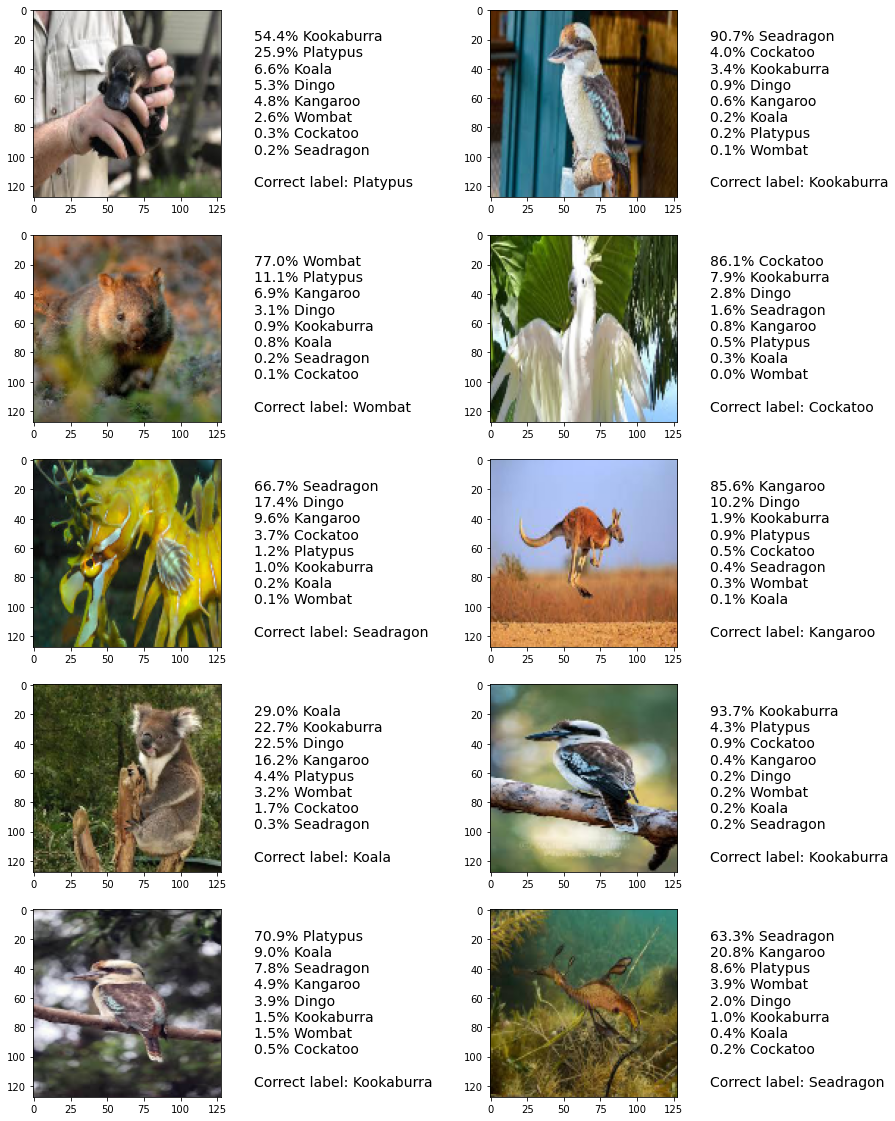

In [131]:
fig = plt.figure(figsize=(15, 20))

for i in range(10):
    categories = list(enc.categories_[0])
    correct = categories[np.argmax(y_test[i])]
    pred = list(zip(list(y_test_pred[i]), categories))
    pred.sort(reverse=True)
    pred_str = ""
    for prob, animal in pred:
        pred_str += "{prob:.1%} {animal}\n".format(prob=prob, animal=animal)
    pred_str += "\nCorrect label: {label}".format(label=correct)
    ax = plt.subplot(5, 2, i+1)
    ax.imshow(X_test[i])
    ax.text(150, 120, pred_str, size=14)
plt.savefig(os.path.join('Plots', 'example_predictions.jpg'), dpi=200, bbox_inches='tight')
plt.show()

## Visualise filters and feature maps

To see the inner workings of the CNN

Method from https://www.kaggle.com/code/arpitjain007/guide-to-visualize-filters-and-feature-maps-in-cnn

### Filters

In [57]:
filters, bias = final_model.layers[0].get_weights()

In [58]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

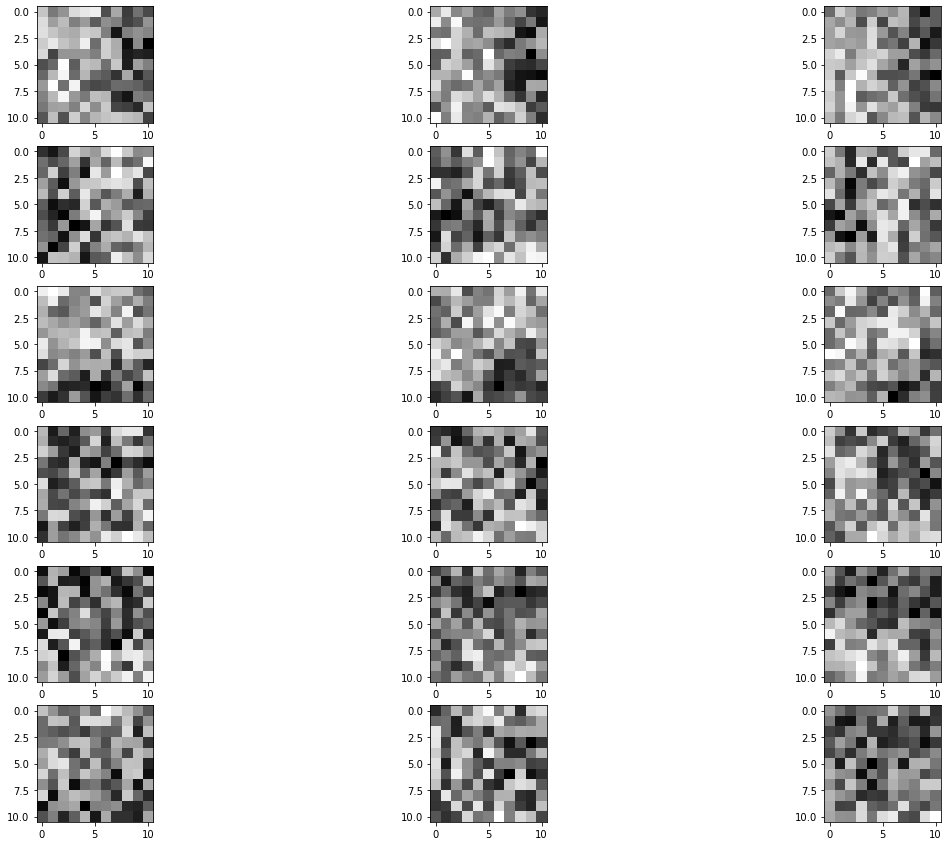

In [59]:
n_filters = 6
ix = 1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()

### Feature maps

In [60]:
for i in range(len(final_model.layers)):
    layer = final_model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

0 conv2d_3 (None, 32, 32, 64)
2 conv2d_4 (None, 16, 16, 128)
4 conv2d_5 (None, 8, 8, 256)


In [61]:
layers_idx = [0, 2, 4]
outputs = [final_model.layers[i].output for i in layers_idx]
visual_model = Model(inputs=final_model.inputs, outputs = outputs)

In [62]:
image = np.expand_dims(X_es[0], axis=0)

1/1 [==============================] - 0s 37ms/step


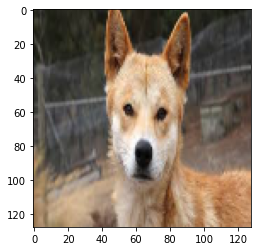

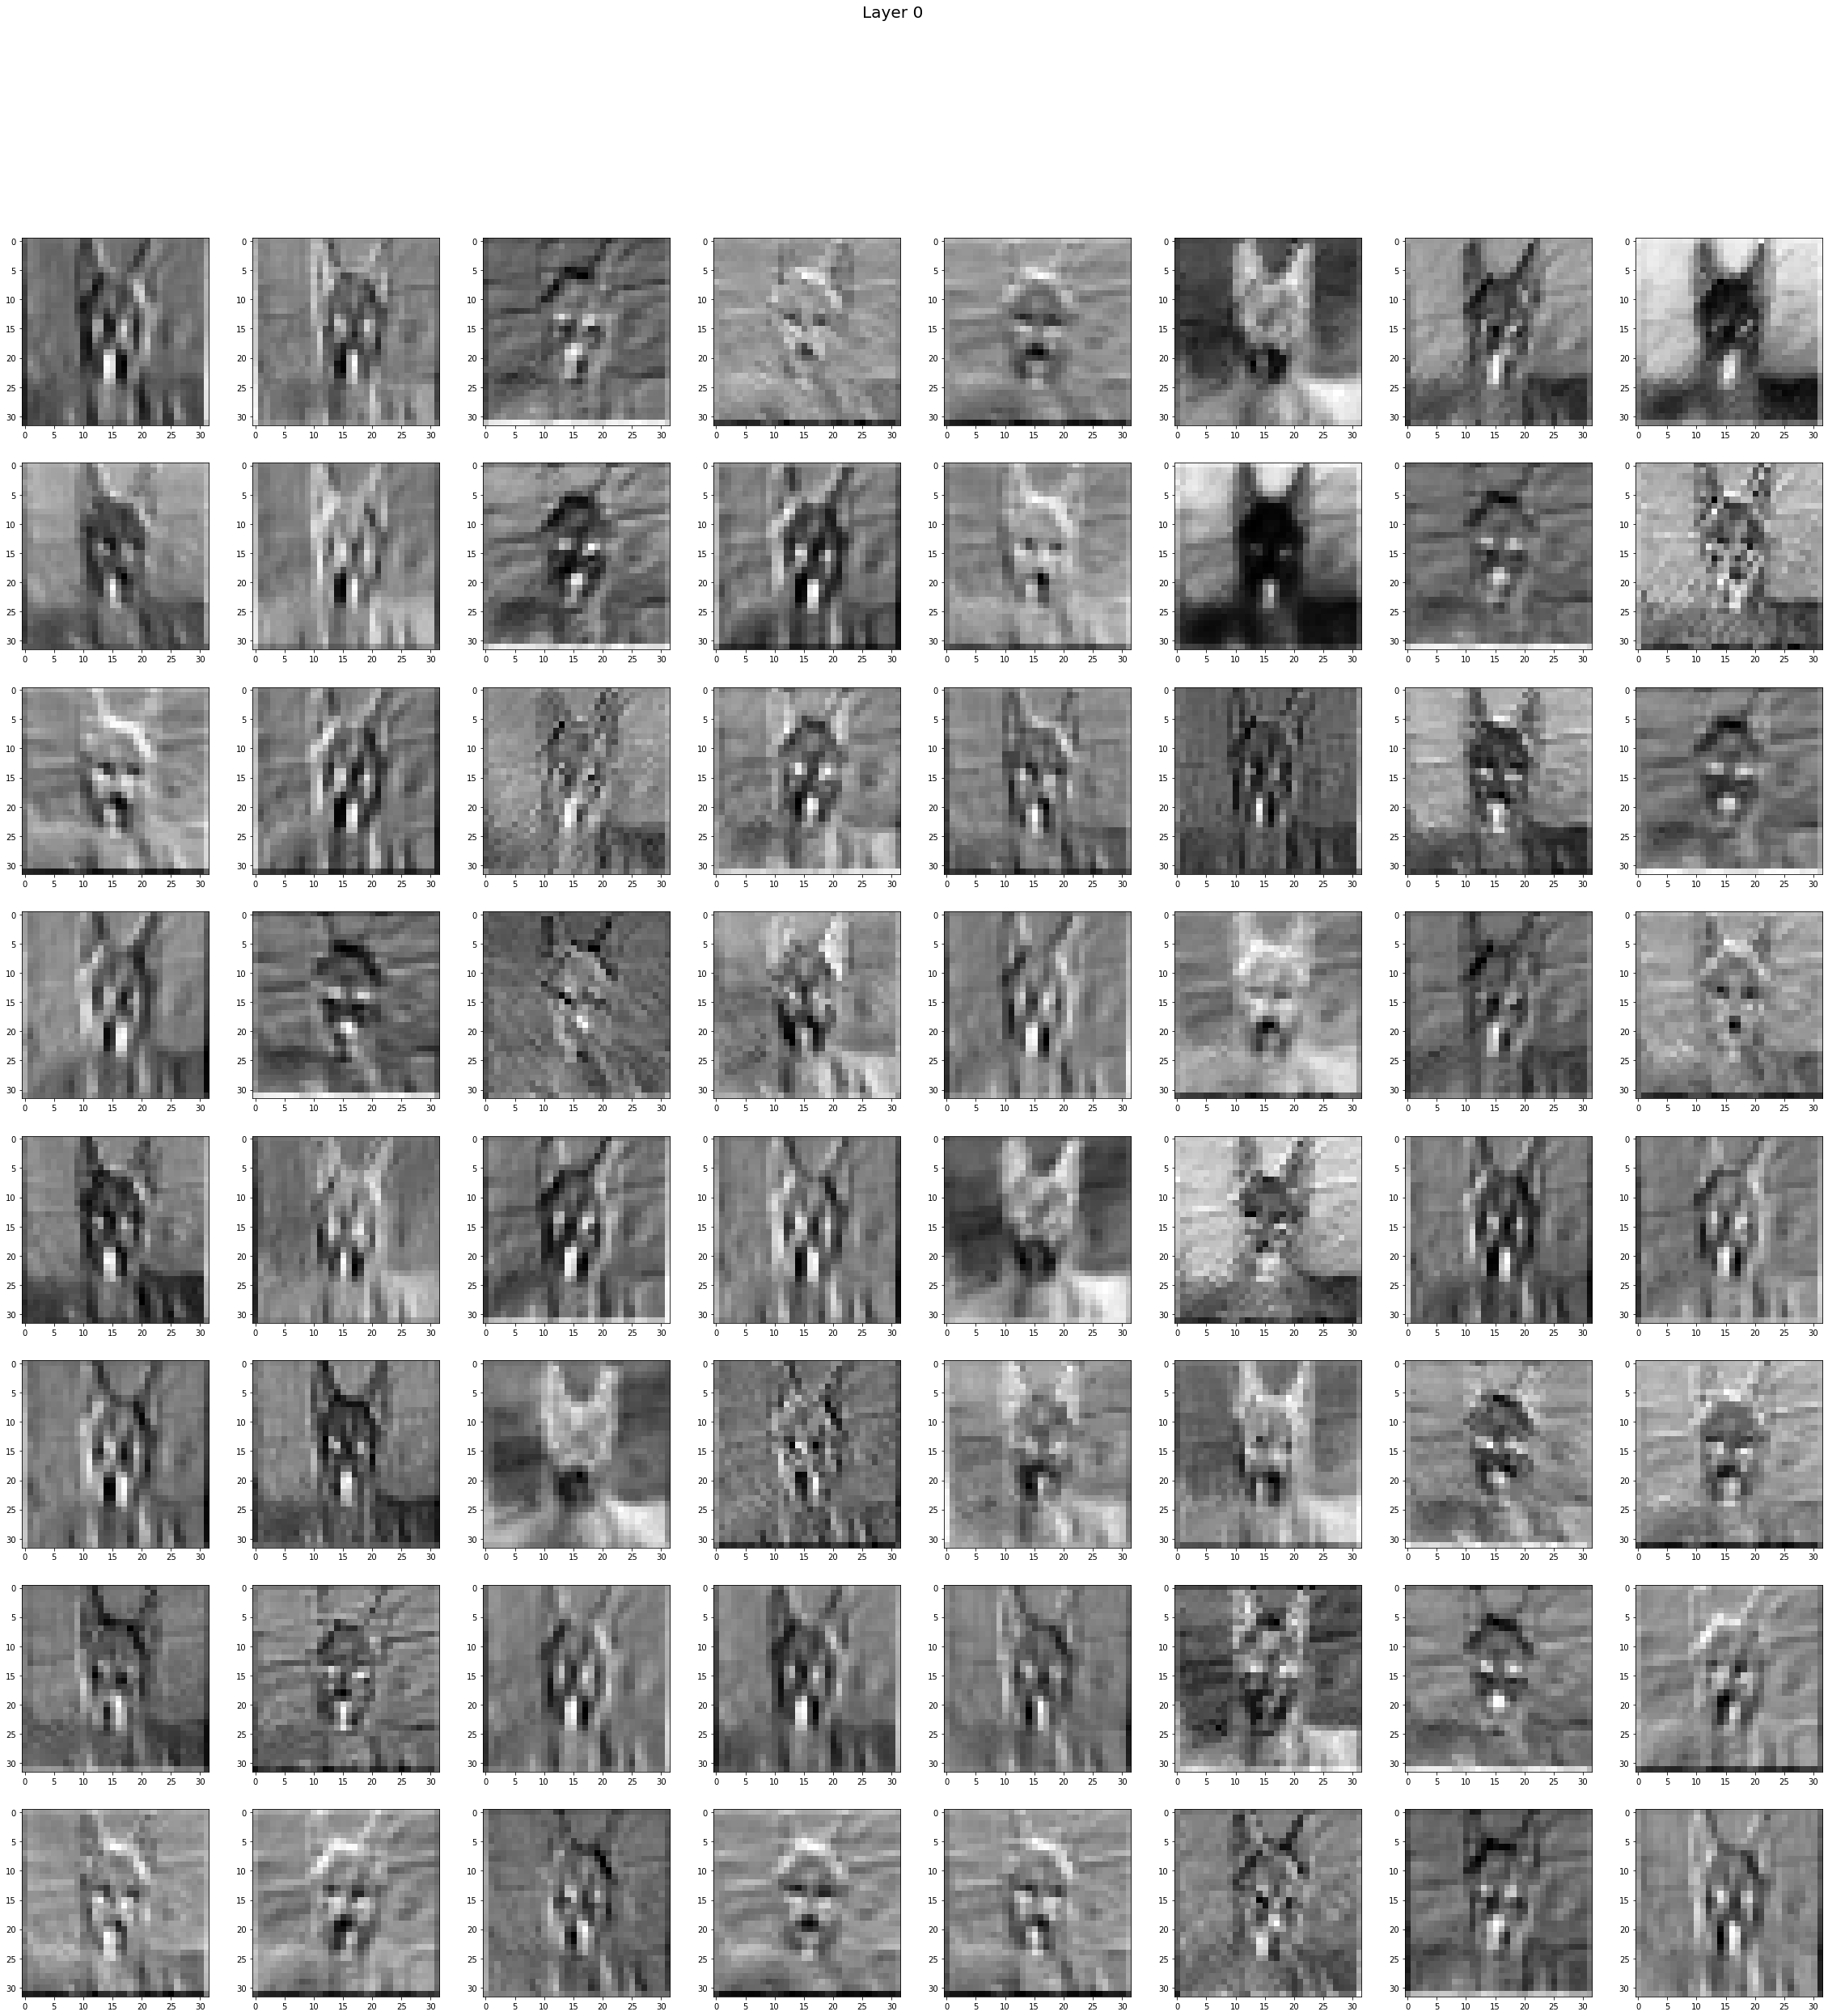

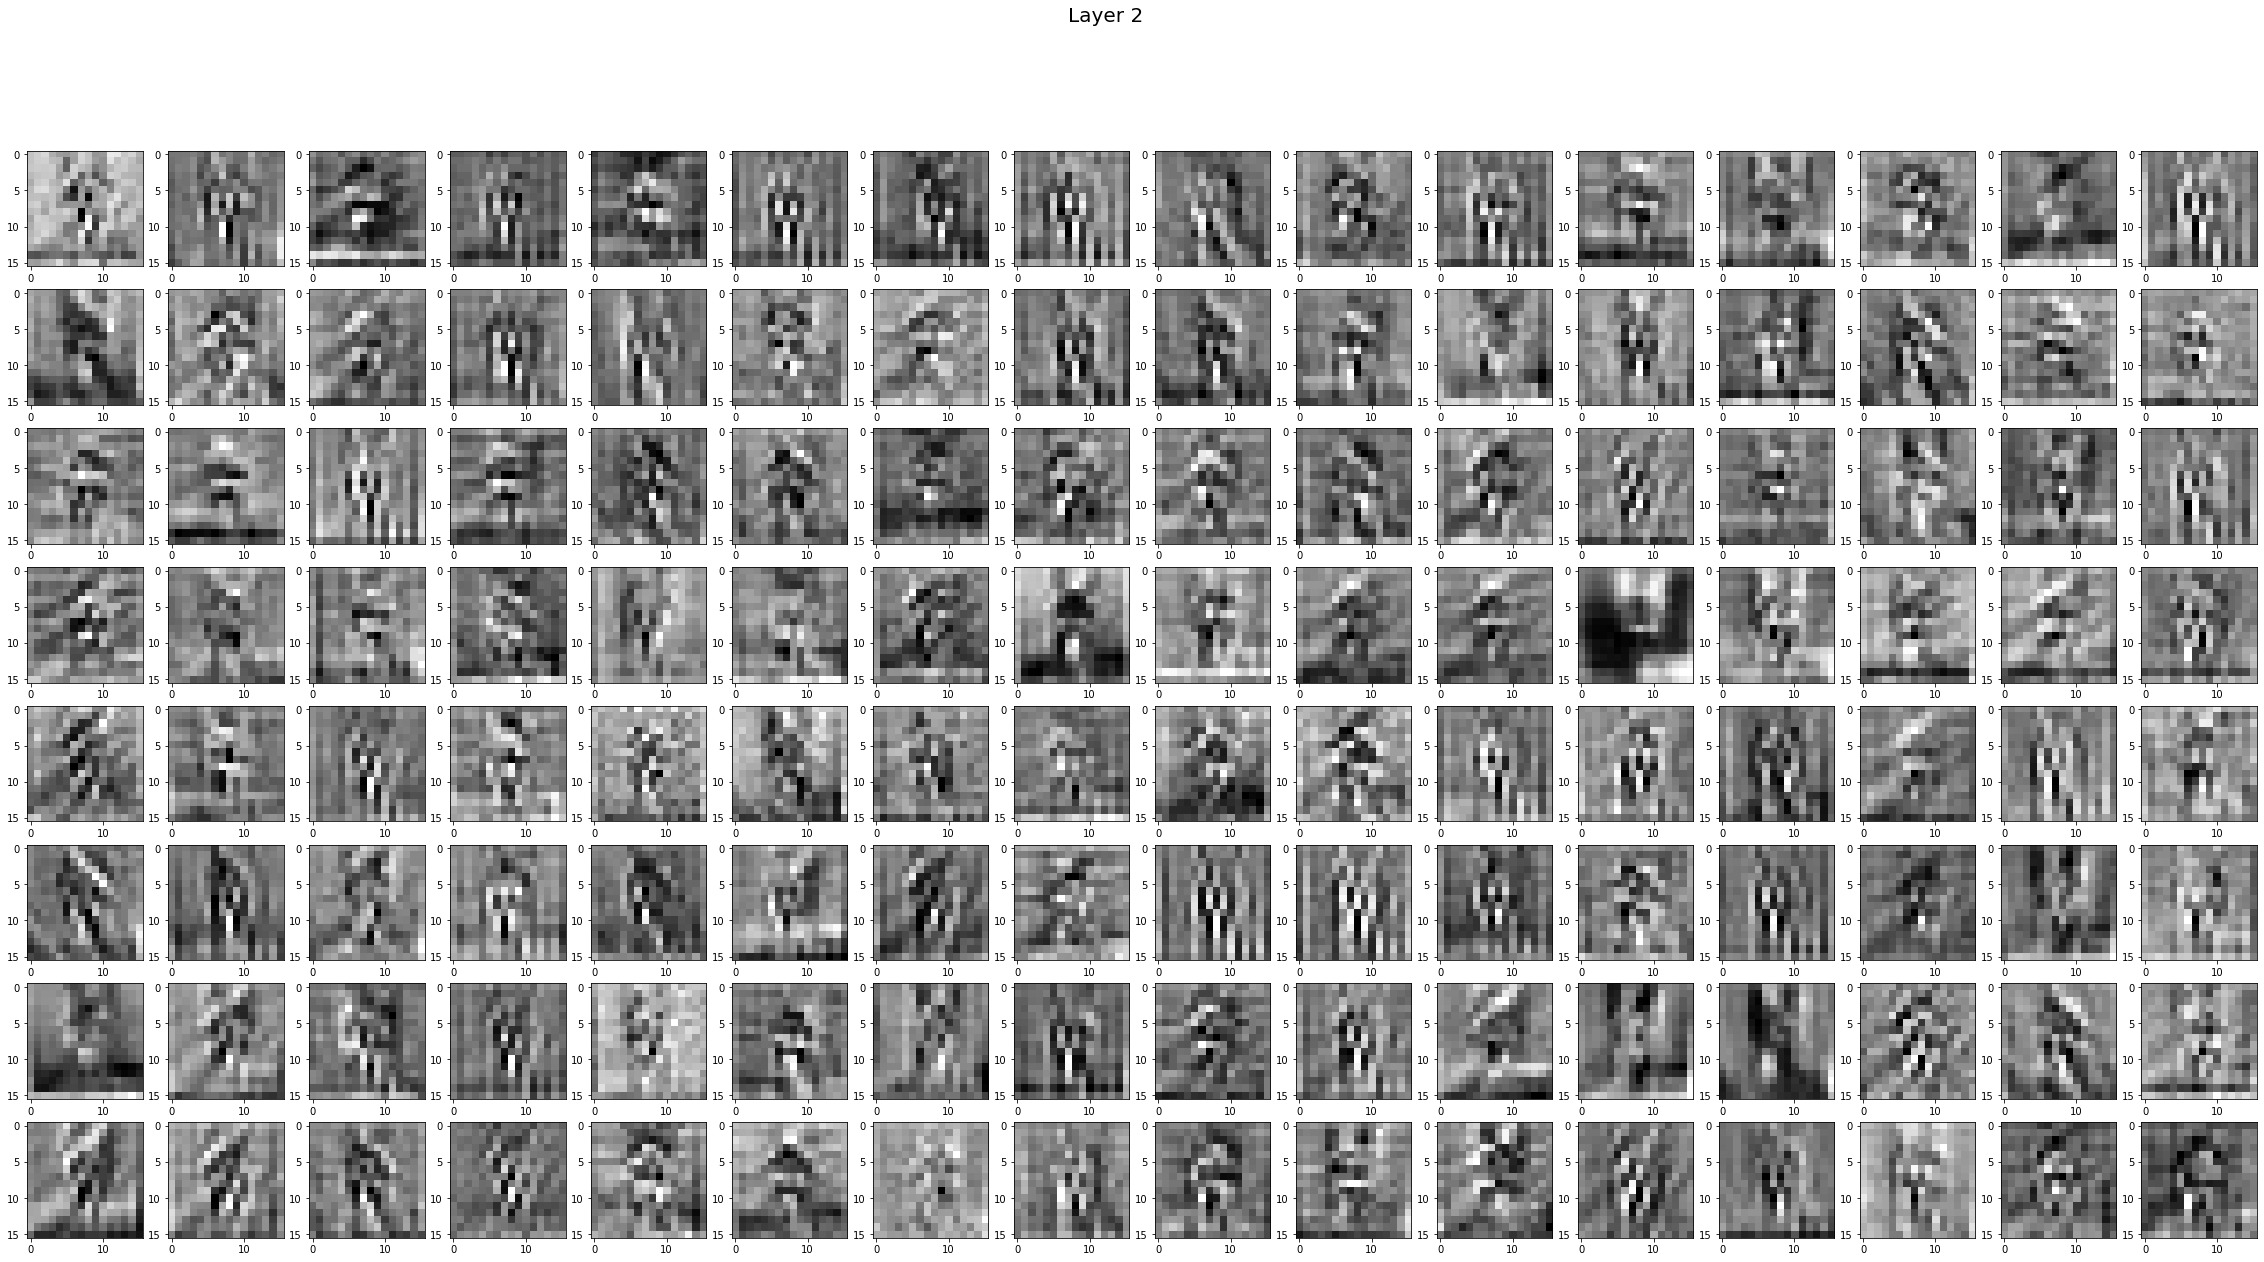

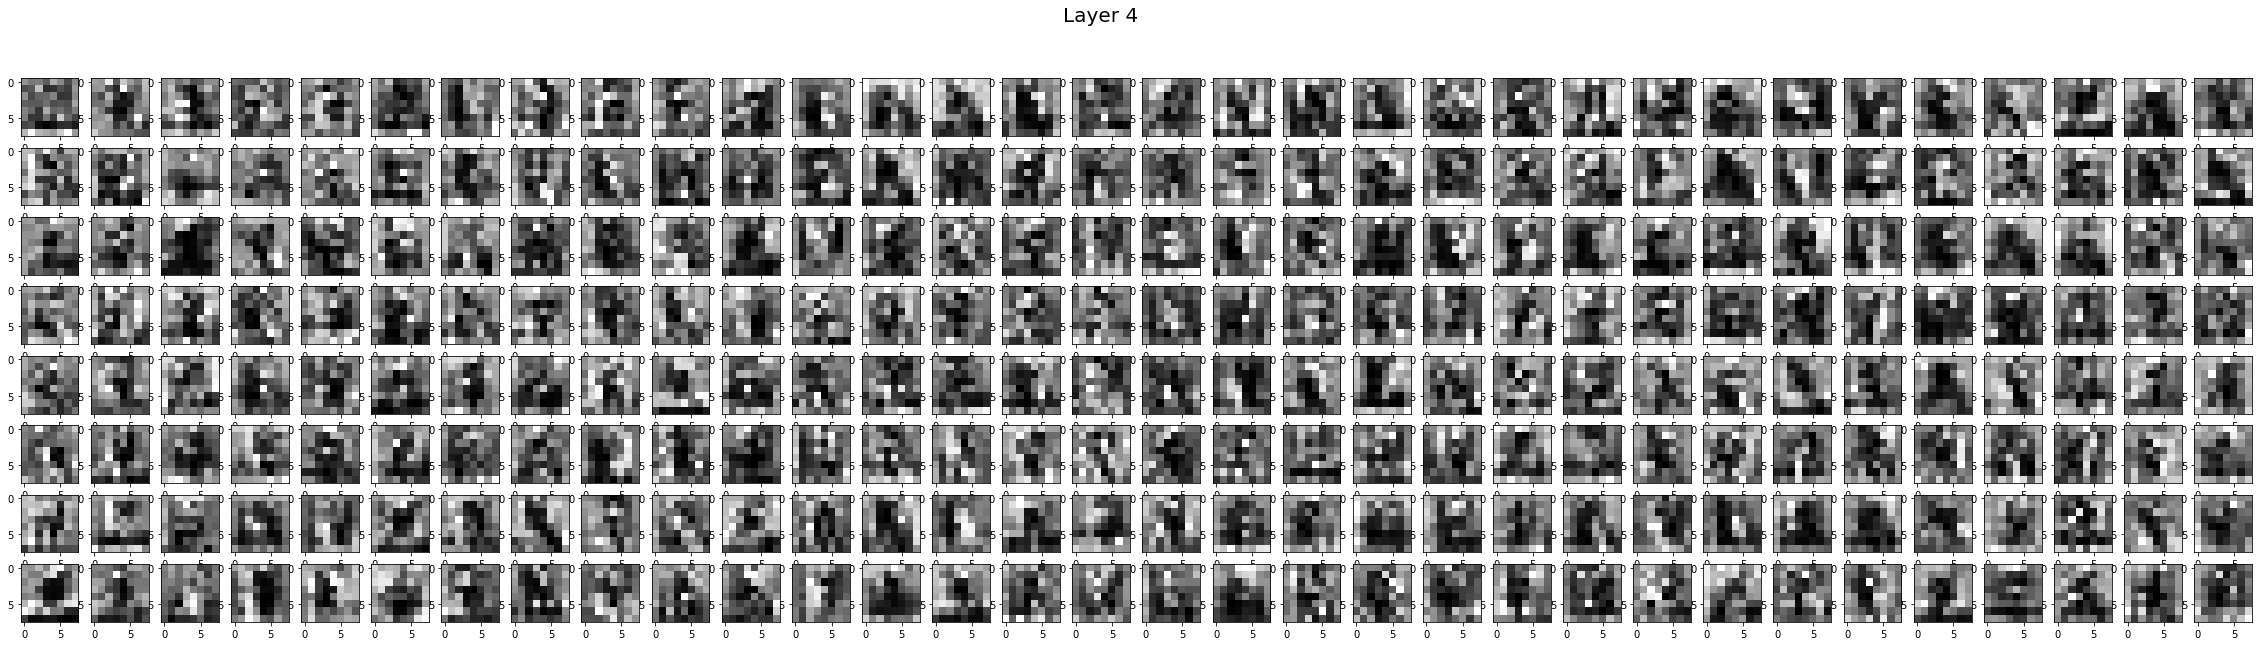

In [63]:
feature_map = visual_model.predict(image)

plt.imshow(X_es[0])
plt.show()

for i,fmap in zip(layers_idx, feature_map):
    
    
    fig = plt.figure(figsize=(40, 40/int(fmap.shape[3]/64)))
    fig.suptitle("Layer {}".format(i), fontsize=20)
    for i in range(fmap.shape[3]):

        plt.subplot(8, round(fmap.shape[3]/8), i+1)
        plt.imshow(fmap[0, :, :, i] , cmap='gray')
    
plt.show()

Hard to see any significant patterns, but the well-known fact that layers get more and more abstract as they get deeper is definitely evident here.